In [2]:
import requests
import pandas as pd
import csv
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import math
from numba import njit
from numba.typed import List
import time
import cmath


# 외삽 데이터 가져오기 위한 함수들 모음

f=open('period table.csv','r')
Pt = csv.reader(f)
f.close()

def compnents_fmul(chem_fmul):
    words = list(chem_fmul)+["1","1"]
    list_elems = []
    for i in range(len(words)-2):
        if words[i].isupper():
            if words[i+1].islower():
                if words[i+2].isdigit():
                    list_elems.append([words[i]+words[i+1],words[i+2]])
                else:
                    list_elems.append([words[i]+words[i+1],1])
            elif words[i+1].isdigit():
                list_elems.append([words[i],words[i+1]])
            else:
                list_elems.append([words[i],1])
    return list_elems


def getf(element):

    # Send an HTTP GET request to the URL
    response = requests.get('https://henke.lbl.gov/optical_constants/sf/'+element.lower()+'.nff')
    if response.status_code == 200:
        content = StringIO(response.text)
        df = pd.read_csv(content, sep='\t')
    else: print("에러")

    df = df.reset_index()
    df = df.drop('f2',axis = 1)
    df.columns = ['E','f1','f2']
    df = df.assign(newf1=math.nan)
#     df.plot(kind = 'scatter',x='E', y='f1')
#     plt.show()
        
    return df

def get_KK_f1(list_E,list_f1,list_f2):
    
    def g(x,y):
        if x==y:
            return (x+y)*math.log(x+y)
        elif y == math.inf:
            return 0
        else:
            return (x+y)*math.log(x+y)+(x-y)*math.log(abs(x-y))

    # 리핏 메뉴얼에 적혀있는 방법인데 내가 수정(리핏틀림!)
    def kk_linearfit(w,w0,w1,w2):
        return 1/math.pi*(g(w0,w)/(w1-w0)-(w2-w0)*g(w1,w)/(w1-w0)/(w2-w1)+g(w2,w)/(w2-w1))

    # 초반 외삽 (x^2으로 피팅)
    def kk_expol_front(w,w1,w2):
        def f(w,w1,w2):
            if -1*w == w1:
                return 0
            else:
                return (w**2/w1**2-(w2+w)/(w2-w1))*math.log(abs(w1+w))
        return 1/math.pi*(-1-2*w**2/w1**2*math.log(w)+g(w2,w)/(w2-w1)+f(w,w1,w2)+f(-1*w,w1,w2))

    # 후반 외삽 (x^-2으로 피팅) 중요 틀린 것 같다. 다시 계산해보자. x값에 대해 편하게 바꿀 수 있는 함수로 만들고 싶은 바람이 있다.
    def kk_expol_end2(w,w0,w1):
        def f(w,w0,w1):
            if -1*w == w1:
                return 0
            else:
                return (w1/w**2-(w0+w)/(w1-w0))*math.log(abs(w1+w))
        return 1/math.pi*(2-2*w1/w**2*math.log(w1)+g(w0,w)/(w1-w0)+f(w,w0,w1)+f(-1*w,w0,w1))
    
    # 후반 외삽 (x^-1으로 피팅) 
    def kk_expol_end1(w,w0,w1):
        def f(w,w0,w1):
            if -1*w == w1:
                return 0
            else:
                return (w1/w-(w0+w)/(w1-w0))*math.log(abs(w1+w))
        return 1/math.pi*(2+g(w0,w)/(w1-w0)+f(w,w0,w1)+f(-1*w,w0,w1))
    
    list_newf1 = []
    for i in range(len(list_E)):
        w_n=list_E[i]
        kk_sum = 0
        for j in range(len(list_E)):
            if j==0:
                x1 = list_E[0]; x2 = list_E[1]; y = list_f2[0]
                kk_sum += y * kk_expol_front(w_n,x1,x2)
            elif j==len(list_E) - 1:
                x0 = list_E[j-1]; x1 = list_E[j]; y = list_f2[j]
                kk_sum += y * kk_expol_end1(w_n,x0,x1)
            else:
                x0 = list_E[j-1]; x1 = list_E[j]; x2 =list_E[j+1]; y = list_f2[j]
                kk_sum += y * kk_linearfit(w_n,x0,x1,x2)
        list_newf1.append(-1*kk_sum)
    diff = list_f1[300]-list_newf1[300]
    list_newf1 = [list_newf1[i] + diff for i in range(len(list_E))]
    return list_newf1


def invert_reflect(list_elems,num_of_dens): #number of density는 옹스트롬^-3 단위
    all_atom = 0
    for elem in list_elems:
        all_atom += int(elem[1])  #앞으로 이거 float으로 바꾸든가 하자.
    
    for elem in list_elems:
        df=elem[2] ;del elem[2]
        for i in range(len(df)):
            f=complex(df.loc[i,'newf1'],-1*df.loc[i,'f2'])
            a=int(elem[1])/all_atom*num_of_dens/math.pi*4.39e3/df.loc[i,'E']**2
            df.loc[i,elem[0]+'af'] = a*f
        df = df.drop(['f1','f2','newf1'], axis = 1)
        if not 'df_R' in locals():
            df_R = df
        else:
            df_R = pd.merge(df_R, df)
    
    for i in range(len(df_R)):
        e = 1
        for elem in list_elems:
            e -= df_R.loc[i,elem[0]+'af']
        N=cmath.sqrt(e)
        R=abs((1-N)/(1+N)).real
        df_R.loc[i,'R'] = R**2
        df_R.loc[i,'W'] = df_R.loc[i,'E'] * 8065.73
    return df_R



def graph_f1(df,elements):
    print(elements)
    plt.plot(df['E'].tolist(), df['f1'].tolist(),df['E'].tolist(), df['newf1'].tolist())
    plt.xscale('log')
    plt.xlim([10, 30000])
    plt.ylim([-10, 90])
    plt.show()
    return 0

def graph_R(df,typ="E"):
    lastpoint = len(df)-1
    plt.plot(df[typ].tolist(), df['R'].tolist())
    x = np.logspace(np.log10(df.loc[lastpoint,typ]), np.log10(1e4),20000)
    a = df.loc[lastpoint,typ]**4*df.loc[lastpoint,'R']
    plt.plot(x,x**(-4)*a)
    plt.xscale('log')
    plt.yscale('log')
#     plt.xlim([10, 30000])
#     plt.ylim([5e-4, 1])
    plt.show()
    return 0
    

    
def get_expolR(chem_fmul,num_of_dens=4/68,typ='E'): #마지막으로 전부 구동시키는 함수
    elements = compnents_fmul(chem_fmul)
    for i in range(len(elements)):
        df = getf(elements[i][0])
        df['newf1'] = get_KK_f1(df['E'].tolist(),df['f1'].tolist(),df['f2'].tolist())
        elements[i].append(df)
#         graph_f1(df,elements[i][0])
    df_R = invert_reflect(elements,num_of_dens)
    graph_R(df_R,typ)
    if typ == 'E':
        return df_R.iloc[:,[0,-2]] #0:E,-2:R,-1:w
    else:
        return df_R.iloc[:,[0,-1]] #0:E,-2:R,-1:w

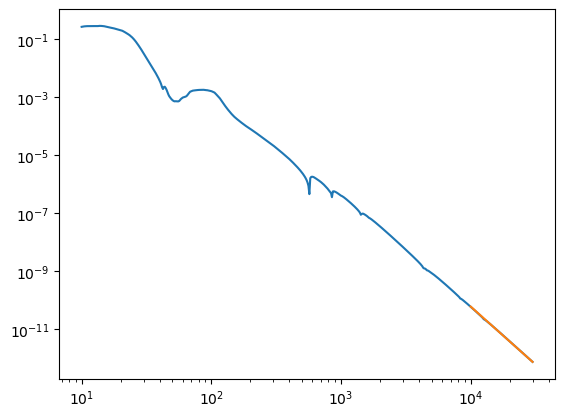

Elapsed Time (pure python) = 11.76443076133728


In [3]:
start = time.time()

expol_df = get_expolR("NiTeSe")

end = time.time()
print(f"Elapsed Time (pure python) = {end - start}")

expol_df.to_csv("expol.csv", mode='w')

In [243]:
def get_KK_pi(tagtlist_E,list_E,list_R):
    
    def g(x,y):
        if x==y:
            return (x+y)*math.log(x+y)/2/x
        else:
            return (x+y)*math.log(x+y)/2/x+(x-y)*math.log(abs(x-y))/2/x
    def h(x,y,z):
        return (x+z)*math.log(x+y)/2/x+(x-z)*math.log(abs(x-y))/2/x

    def kk_linearfit(w,w0,w1,w2):
        return g(w,w0)/(w0-w1)+(w0-w2)*g(w,w1)/(w1-w0)/(w1-w2)+g(w,w2)/(w1-w2)
    def kk_linear_front(w,w1,w2):
        return g(w,w2)/(w1-w2)-h(w,w1,w2)/(w1-w2)
    
    def kk_expol_veryhigh(w,a,t=6): #ln(x)일때의 kk relaion변환
        def f(fron,rear):
            return math.log(fron)*math.log(abs(rear-1)/(rear+1))
        def furier(w,a):
            fsum = 0
            for n in range(t):
                fsum += 2/(2*n+1)**2*(w/a)**(2*n+1)
            return fsum
        return furier(w,a)/2/w+f(w/a,w/a)/2/w-f(w,a/w)/2/w

    list_newpi = []
    for i in range(len(tagtlist_E)):
        w_n=tagtlist_E[i]
        kk_sum = 0
        for j in range(len(list_E)-1):
            if i==0:
                w1=list_E[j]; w2=list_E[j+1]; y = math.log(list_R[j])
                kk_sum += y * kk_linear_front(w_n,w1,w2)
            else:
                x0 = list_E[j-1]; x1 = list_E[j]; x2 =list_E[j+1]; y = math.log(list_R[j])
                kk_sum += y * kk_linearfit(w_n,x0,x1,x2)
        list_newpi.append(-1*w_n/math.pi*kk_sum)
    return list_newpi

def add_high_R(expol_df,typ='E'):
    
    x = np.logspace(np.log10(expol_df.loc[lastpoint,typ]), np.log10(1e40),2000)
    a = expol_df.loc[lastpoint,typ]**4*expol_df.loc[lastpoint,'R']
    r = x**-4*a
    df = pd.DataFrame({typ:x[1:],'R':r[1:]})
    expol_df = pd.concat([expol_df,df], ignore_index=True)
#     expol_df = expol_df.sort_values(by='E')

#     expol_df.plot(kind = 'scatter',x='E', y='R')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.show()

    return expol_df
    
df = add_high_R(expol_df)
pd.set_option('display.max_rows', None)
print(df.loc[35,'E'])
df

# def get_pi(data_df,expol_df):
    

# def append_expol(df):
#     df[]
# lastpoint = len(df)-1
# list_E = np.logspace(np.log10(100000), np.log10(1e40),20000)
# list_R = df.loc[lastpoint,'E']**4*df.loc[lastpoint,'R']*list_E**-4
# print(get_KK_f2(500,list_E,list_f2))

12.9268


,E,R
0,1.000000e+00,3.000000e+00
1,2.000000e+00,6.000000e+00
2,3.000000e+00,9.000000e+00
3,4.000000e+00,1.200000e+01
4,5.000000e+00,1.500000e+01
5,6.000000e+00,1.800000e+01
6,7.000000e+00,2.100000e+01
7,8.000000e+00,2.400000e+01
8,9.000000e+00,2.700000e+01
9,1.000000e+01,3.000000e+01


0.0035212791136989027


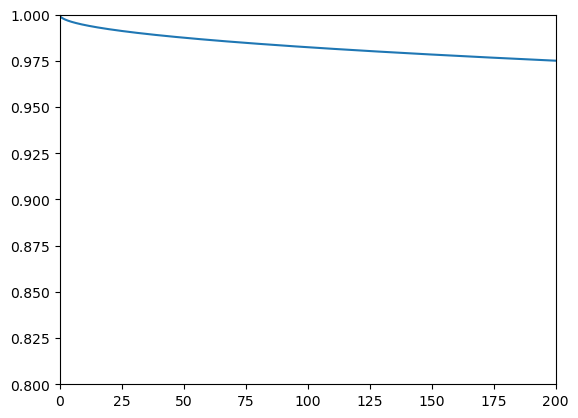

[1.00000000e-07 1.02169952e-07 1.04386991e-07 1.06652139e-07
 1.08966440e-07 1.11330960e-07 1.13746788e-07 1.16215039e-07
 1.18736850e-07 1.21313383e-07 1.23945825e-07 1.26635391e-07
 1.29383318e-07 1.32190874e-07 1.35059353e-07 1.37990077e-07
 1.40984396e-07 1.44043690e-07 1.47169369e-07 1.50362874e-07
 1.53625676e-07 1.56959280e-07 1.60365222e-07 1.63845070e-07
 1.67400430e-07 1.71032940e-07 1.74744273e-07 1.78536140e-07
 1.82410289e-07 1.86368505e-07 1.90412613e-07 1.94544476e-07
 1.98765998e-07 2.03079125e-07 2.07485845e-07 2.11988189e-07
 2.16588231e-07 2.21288093e-07 2.26089938e-07 2.30995982e-07
 2.36008485e-07 2.41129756e-07 2.46362157e-07 2.51708098e-07
 2.57170043e-07 2.62750510e-07 2.68452071e-07 2.74277353e-07
 2.80229040e-07 2.86309877e-07 2.92522664e-07 2.98870267e-07
 3.05355609e-07 3.11981680e-07 3.18751533e-07 3.25668289e-07
 3.32735135e-07 3.39955329e-07 3.47332197e-07 3.54869140e-07
 3.62569631e-07 3.70437219e-07 3.78475530e-07 3.86688268e-07
 3.95079219e-07 4.036522

In [5]:
x = np.logspace(np.log10(1E-7), np.log10(206),1000)
X = 208.29 ; Y=0.97459
a = (1-Y)/X**(1/2)
y = 1-a*x**(1/2)
plt.plot(x,y)
# plt.xscale('log')
# plt.yscale('log')
plt.ylim([0.8, 1])
plt.xlim([0,200])
plt.show()
print(x)

fornt_expol_df = pd.DataFrame({'W': x,'R':y})
fornt_expol_df.to_csv("fexpol.csv", mode='w')

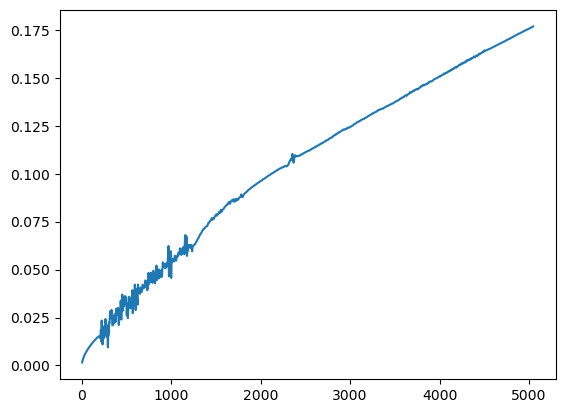

In [58]:
def get_KK_pi(tagtlist_E,list_E,list_R):
    
    def g(x,y):
        if x==y:
            return (x+y)*math.log(x+y)/2/x
        else:
            return (x+y)*math.log(x+y)/2/x+(x-y)*math.log(abs(x-y))/2/x

    def kk_linearfit(w,w0,w1,w2):
        return g(w,w0)/(w0-w1)+(w0-w2)*g(w,w1)/(w1-w0)/(w1-w2)+g(w,w2)/(w1-w2)
    
    list_newpi = []
    for i in range(len(tagtlist_E)):
        w_n=tagtlist_E[i]
        kk_sum = 0
        for j in range(len(list_E)-1): #R(0)=1인 지점은 안했다.
            x0 = list_E[j-1]; x1 = list_E[j]; x2 =list_E[j+1]; y = math.log(list_R[j])
            kk_sum += y * kk_linearfit(w_n,x0,x1,x2)
        list_newpi.append(-1*w_n/math.pi*kk_sum)
    return list_newpi

data = pd.read_csv('data_end.csv')
taget_W = data.loc[800:3500,'W'].tolist()
taget_R = data.loc[800:3500,'R'].tolist()
taget_Rpi = get_KK_pi(taget_W,data['W'].tolist(),data['R'].tolist())
plt.plot(taget_W,taget_Rpi)
plt.show()

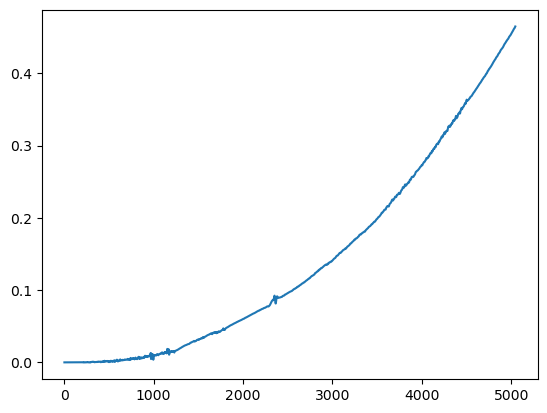

In [70]:
lists = []
for i in range(len(taget_R)):
    r = math.sqrt(taget_R[i])*complex(math.cos(taget_Rpi[i]),math.sin(taget_Rpi[i]))
    N = (1-r)/(1+r)
    e = N**2
    ee = (0-1j)*e
    s = 2*math.pi*(0-1j)*taget_W[i]*e/377
#     print(e)
    lists.append(s.imag)
plt.plot(taget_W,lists)
plt.show()
